In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.evaluate import compute_prdc
from tqdm import tqdm 

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


**Util function**

In [2]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

## Step 1: Initialize data

In [3]:
dataset_config = {'dataset_path': '/home/icb/alessandro.palma/environment/celldreamer/datasets/processed/hlca_core.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


learnt_autoencoder


## Step 2: Initialize encoder

In [4]:
encoder_config = {
    "x0_from_x_kwargs": {
        # "dims": [512, 256, 50],
        "dims": [500, 300, 200],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_hlca_core_200/5ae24a87-5508-4711-974a-590ab6d749a6/checkpoints/epoch_199.ckpt"
# state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_hlca_core/118e6ec2-de99-4b29-9bd7-25ac82c13d06/checkpoints/epoch_199.ckpt"

In [5]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)
encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [6]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [7]:
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_hlca_core/c2cc82f5-94a4-4dde-ab7c-24cc88e7f6d7/checkpoints/last.ckpt")
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_hlca_core_200/a353d142-e48e-4998-b0c5-1ad70bcd8db5/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model

MLPTimeStep(
  (time_embedder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (size_factor_embedder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (condition_embedder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (net_in): Linear(in_features=200, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x ResnetBlock(
      (net1): Sequential(
        (0): SiLU()
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (cond_proj): Sequential(
        (0): SiLU()
        (1): Linear(in_features=128, out_features=64, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=64, out_features=

## 

In [8]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.6452, -1.5938, -0.1591,  ..., -1.0042,  1.6492,  0.9685],
        [-0.3961, -0.3079,  0.6507,  ..., -0.1639,  0.4762,  0.0618],
        [ 0.0171, -0.9104,  0.8779,  ...,  0.2869,  0.8233,  0.8647],
        ...,
        [-0.6376, -1.6720, -0.1757,  ...,  0.7336, -0.5051, -1.6615],
        [ 0.2448, -0.2503,  2.5820,  ...,  0.3218, -0.4249,  0.4384],
        [-0.6487,  1.0392,  1.5497,  ..., -1.8610, -0.8813, -0.4798]],
       device='cuda:0', requires_grad=True)


Initializations

In [9]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2000, out_features=500, bias=True)
          (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=500, out_features=300, bias=True)
          (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=300, out_features=200, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=200, out_features=300, bias=True)
          (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=300, out_features=500, bias=True)
        

**Check the data**

In [10]:
adata_original = sc.read_h5ad(data_path)
sc.pp.subsample(adata_original, fraction=0.20)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

**Collect checkpoints and run**

General conditional

In [11]:
dataset.id2cov

{'cell_type': {'B cell': 0,
  'CD1c-positive myeloid dendritic cell': 1,
  'CD4-positive, alpha-beta T cell': 2,
  'CD8-positive, alpha-beta T cell': 3,
  'T cell': 4,
  'acinar cell': 5,
  'alveolar macrophage': 6,
  'alveolar type 1 fibroblast cell': 7,
  'alveolar type 2 fibroblast cell': 8,
  'bronchial goblet cell': 9,
  'bronchus fibroblast of lung': 10,
  'brush cell of trachebronchial tree': 11,
  'capillary endothelial cell': 12,
  'ciliated columnar cell of tracheobronchial tree': 13,
  'classical monocyte': 14,
  'club cell': 15,
  'conventional dendritic cell': 16,
  'dendritic cell': 17,
  'elicited macrophage': 18,
  'endothelial cell of lymphatic vessel': 19,
  'epithelial cell of alveolus of lung': 20,
  'epithelial cell of lower respiratory tract': 21,
  'fibroblast': 22,
  'hematopoietic stem cell': 23,
  'ionocyte': 24,
  'lung macrophage': 25,
  'lung neuroendocrine cell': 26,
  'lung pericyte': 27,
  'mast cell': 28,
  'mesothelial cell': 29,
  'mucus secreting cel

In [12]:
X_generated_list = []
classes_str = []
for _ in tqdm(range(100)):
    num_indices =1000
    index_range = len(X)
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.cell_type)
    classes_str += classes
    classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes]).cuda()
    

    log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
    X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                covariate="cell_type", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

    X_generated_list.append(X_generated.to("cpu"))

100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


Single condition

In [13]:
X_generated_list = torch.cat(X_generated_list, dim=0)

In [14]:
X_generated_list.shape

torch.Size([100000, 2000])

In [15]:
dataset.id2cov["cell_type"]

{'B cell': 0,
 'CD1c-positive myeloid dendritic cell': 1,
 'CD4-positive, alpha-beta T cell': 2,
 'CD8-positive, alpha-beta T cell': 3,
 'T cell': 4,
 'acinar cell': 5,
 'alveolar macrophage': 6,
 'alveolar type 1 fibroblast cell': 7,
 'alveolar type 2 fibroblast cell': 8,
 'bronchial goblet cell': 9,
 'bronchus fibroblast of lung': 10,
 'brush cell of trachebronchial tree': 11,
 'capillary endothelial cell': 12,
 'ciliated columnar cell of tracheobronchial tree': 13,
 'classical monocyte': 14,
 'club cell': 15,
 'conventional dendritic cell': 16,
 'dendritic cell': 17,
 'elicited macrophage': 18,
 'endothelial cell of lymphatic vessel': 19,
 'epithelial cell of alveolus of lung': 20,
 'epithelial cell of lower respiratory tract': 21,
 'fibroblast': 22,
 'hematopoietic stem cell': 23,
 'ionocyte': 24,
 'lung macrophage': 25,
 'lung neuroendocrine cell': 26,
 'lung pericyte': 27,
 'mast cell': 28,
 'mesothelial cell': 29,
 'mucus secreting cell': 30,
 'multi-ciliated epithelial cell': 3

In [16]:
# # Pick condition 
# condition_name = 'alveolar macrophage'
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()


# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [17]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_list).cpu().numpy()))
adata_generated.obs["classes"] = classes_str

In [18]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

In [19]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

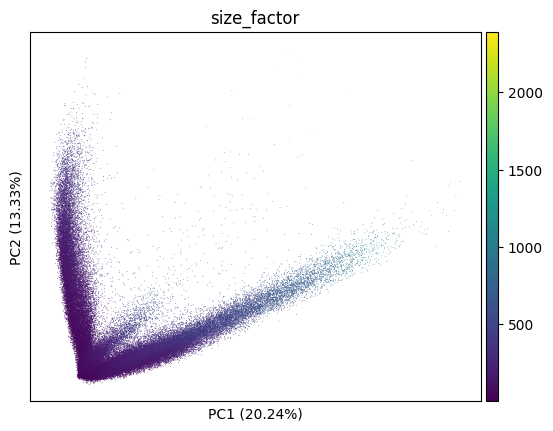

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


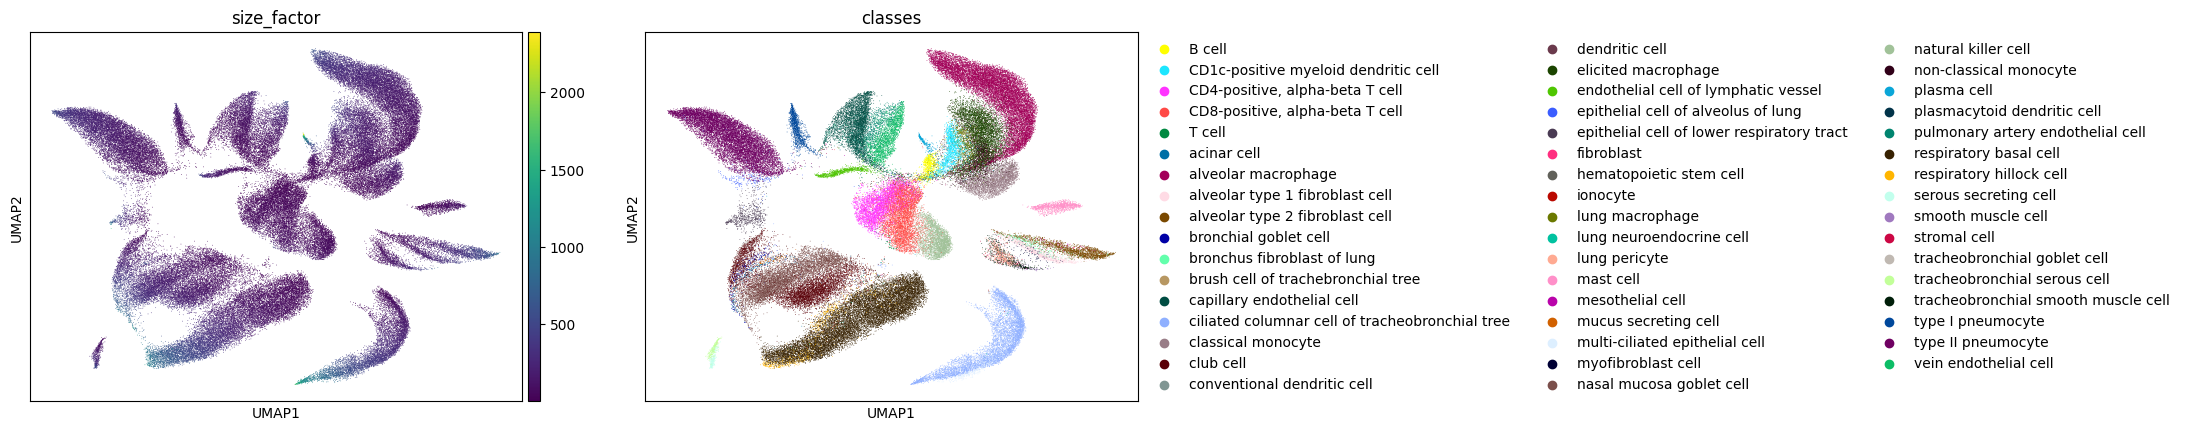

In [20]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "classes"])

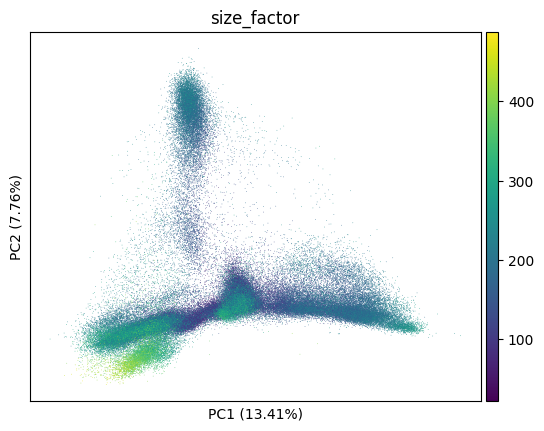

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


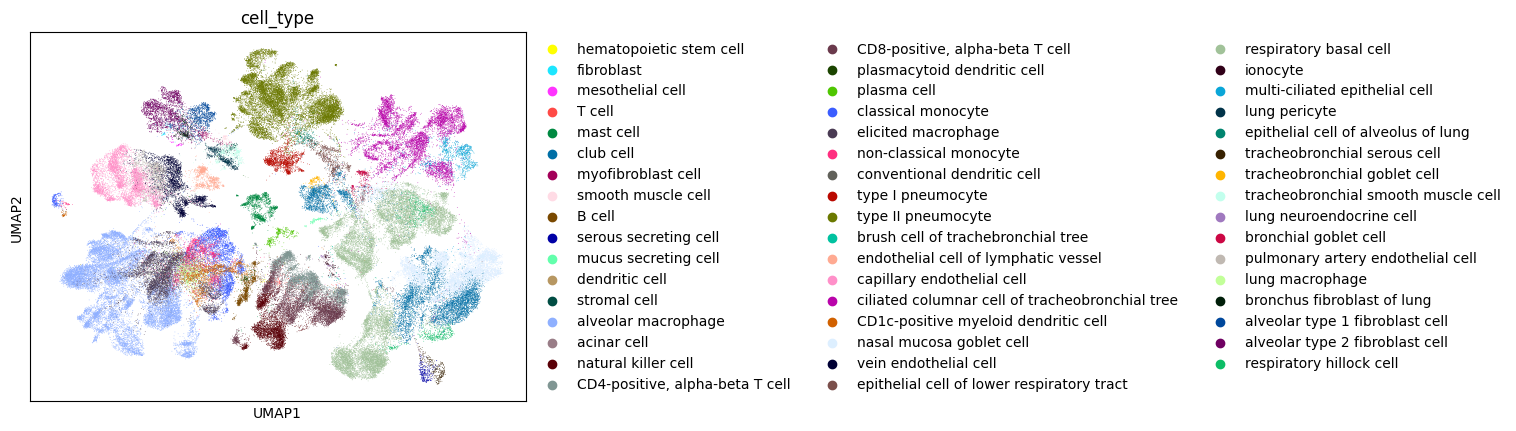

In [21]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="cell_type")

Merge and plot the generated and real data

In [22]:
X_generated.shape

torch.Size([1000, 2000])

In [23]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated_list.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["classes"] = list(adata_original.obs.cell_type)+list(classes_str)

In [24]:
# # If applicable 
# cell_type = list(adata_original.obs.clusters) + [condition_name for _ in range(X_generated.shape[0])]
# dataset_type["cell_type"] = cell_type

In [25]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated_list], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [26]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


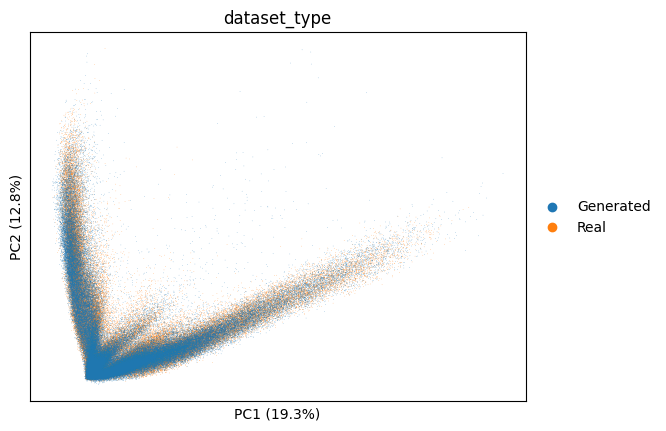

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

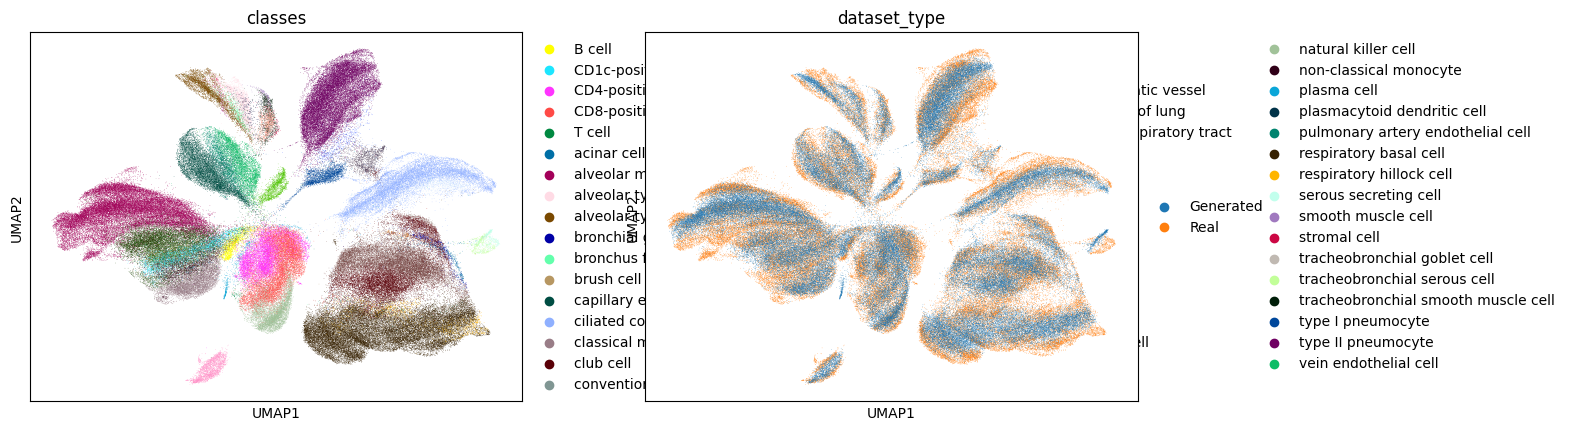

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


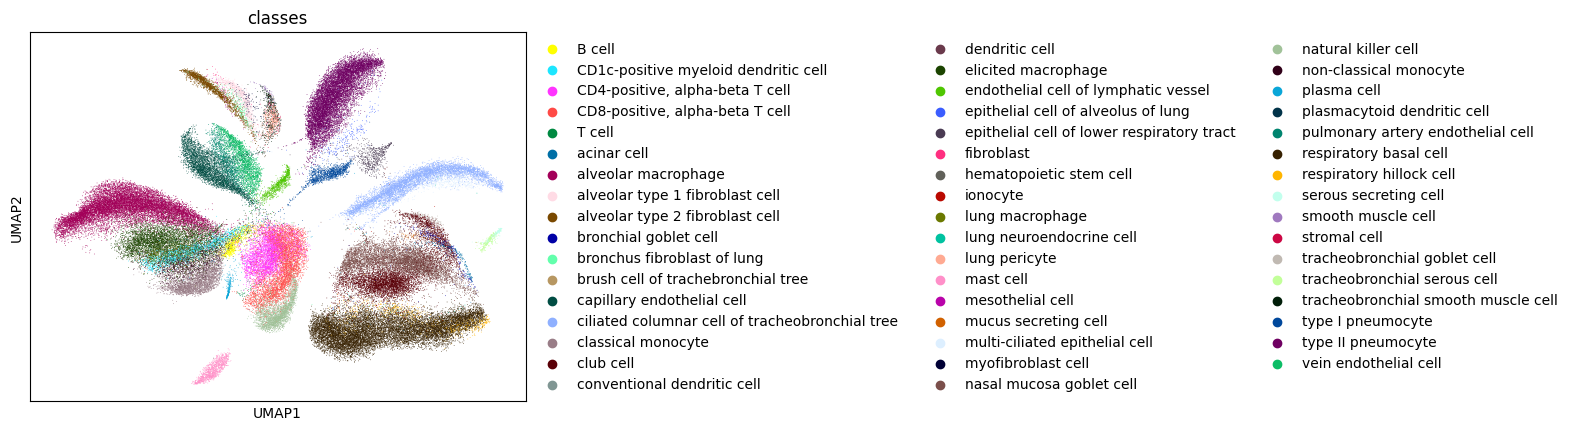

In [39]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["classes","dataset_type"])
# sc.pl.umap(adata_merged, color=["classes"])
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Generated"], color=["classes"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

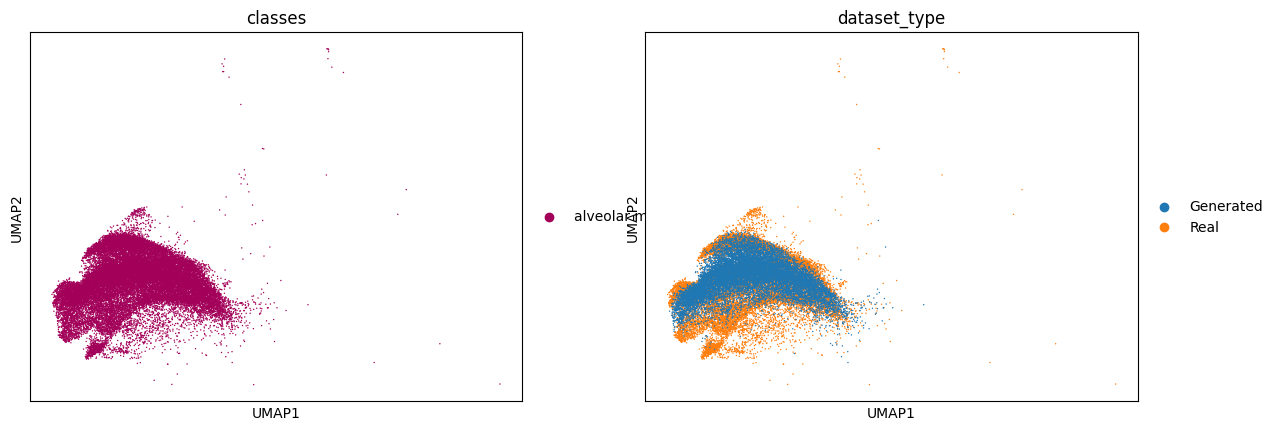

In [40]:
sc.pl.umap(adata_merged[adata_merged.obs.classes=="alveolar macrophage"], color=["classes","dataset_type"])

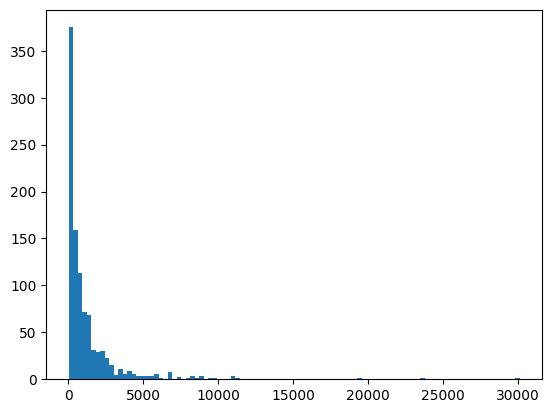

In [29]:
plt.hist(X_generated.sum(1), 100)
plt.show()

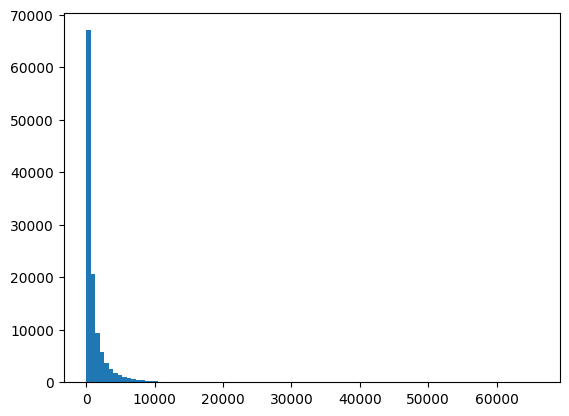

In [30]:
plt.hist(X.sum(1), 100)
plt.show()

In [31]:
(X_generated==0).sum(1).float().mean()

tensor(1874.1899)

In [32]:
(X==0).sum(1).float().mean()

tensor(1876.0004)

In [33]:
X.mean(1).mean()

tensor(0.6118)

In [34]:
X_generated.mean(1).mean()

tensor(0.5959)

In [35]:
adata_original.X.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.82320845, 1.3038287 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [36]:
adata_generated.X.A

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.6931472, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.0986123, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [37]:
normalize_and_compute_metrics(adata_original, adata_generated, sparse=True)

TypeError: normalize_and_compute_metrics() missing 1 required positional argument: 'layer'

In [ ]:
compute_prdc(X, X_generated, 10)